In [60]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [61]:
!pip install sumy

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
from collections import Counter
import nltk
import plotly
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import ibm_db
import ibm_db_dbi
from sumy.utils import get_stop_words
import string
from collections import Counter

In [63]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/wsuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Setting up SQL/Python Environment

In [64]:
# The code was removed by Watson Studio for sharing.

In [65]:
# Formatting dsn in order to make connection
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};"
    "SECURITY={7};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd, dsn_security)

In [66]:
#Connecting to Database
try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database:  bludb as user:  qgs98802 on host:  54a2f15b-5c0f-46df-8954-7e38e612c2bd.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud


In [67]:
pconn = ibm_db_dbi.Connection(conn)

# All Dataframes used in this Project

In [68]:
sql_table = 'nlp_twitter_data_week_1'

In [69]:
#Dataframes at the intersection of the two features we are assessing
overall = f'''SELECT political_alignment, news_sources_type, content, cleaned_tweets, length_of_tweet, day_of_week,
NULLIF(overall_sentiment, 0.0000) AS overall_sentiment, NULLIF (subjectivity, 0.000) AS subjectivity, named_entities,
named_sentiment from {sql_table}'''
overall_df = pd.read_sql(overall, pconn)

conservative_traditional = f"""SELECT political_alignment, news_sources_type, content, cleaned_tweets, length_of_tweet, day_of_week,
NULLIF(overall_sentiment, 0.0000) AS overall_sentiment, NULLIF (subjectivity, 0.000) AS subjectivity, named_entities,
named_sentiment from {sql_table} 
WHERE political_alignment = 'Conservative' AND news_sources_type = 'Traditional' """
con_traditional_df = pd.read_sql(conservative_traditional, pconn)

conservative_politician = f"""SELECT political_alignment, news_sources_type, content, cleaned_tweets, length_of_tweet, day_of_week,
NULLIF(overall_sentiment, 0.0000) AS overall_sentiment, NULLIF (subjectivity, 0.000) AS subjectivity, named_entities,
named_sentiment from {sql_table} 
WHERE political_alignment = 'Conservative' AND news_sources_type = 'Politician' """
con_politician_df = pd.read_sql(conservative_politician, pconn)

conservative_alt = f"""SELECT political_alignment, news_sources_type, content, cleaned_tweets, length_of_tweet, day_of_week,
NULLIF(overall_sentiment, 0.0000) AS overall_sentiment, NULLIF (subjectivity, 0.000) AS subjectivity, named_entities,
named_sentiment from {sql_table} 
WHERE political_alignment = 'Conservative' AND news_sources_type = 'Alternative' """
con_alt_df = pd.read_sql(conservative_alt, pconn)

moderate_traditional = f"""SELECT political_alignment, news_sources_type, content, cleaned_tweets, length_of_tweet, day_of_week,
NULLIF(overall_sentiment, 0.0000) AS overall_sentiment, NULLIF (subjectivity, 0.000) AS subjectivity, named_entities,
named_sentiment from {sql_table}
WHERE political_alignment = 'Moderate' AND news_sources_type = 'Traditional' """
mod_traditional_df = pd.read_sql(moderate_traditional, pconn)

moderate_politician = f"""SELECT political_alignment, news_sources_type, content, cleaned_tweets, length_of_tweet, day_of_week,
NULLIF(overall_sentiment, 0.0000) AS overall_sentiment, NULLIF (subjectivity, 0.000) AS subjectivity, named_entities,
named_sentiment from {sql_table}
WHERE political_alignment = 'Moderate' AND news_sources_type = 'Politician' """
mod_politician_df = pd.read_sql(moderate_politician, pconn)

liberal_traditional = f"""SELECT political_alignment, news_sources_type, content, cleaned_tweets, length_of_tweet, day_of_week,
NULLIF(overall_sentiment, 0.0000) AS overall_sentiment, NULLIF (subjectivity, 0.000) AS subjectivity, named_entities,
named_sentiment from {sql_table} 
WHERE political_alignment = 'Liberal' AND news_sources_type = 'Traditional' """
lib_traditional_df = pd.read_sql(liberal_traditional, pconn)

liberal_politician = f"""SELECT political_alignment, news_sources_type, content, cleaned_tweets, length_of_tweet, day_of_week,
NULLIF(overall_sentiment, 0.0000) AS overall_sentiment, NULLIF (subjectivity, 0.000) AS subjectivity, named_entities,
named_sentiment from {sql_table}
WHERE political_alignment = 'Liberal' AND news_sources_type = 'Politician' """
lib_politician_df = pd.read_sql(liberal_politician, pconn)

liberal_alt = f"""SELECT political_alignment, news_sources_type, content, cleaned_tweets, length_of_tweet, day_of_week,
NULLIF(overall_sentiment, 0.0000) AS overall_sentiment, NULLIF (subjectivity, 0.000) AS subjectivity, named_entities,
named_sentiment from {sql_table} 
WHERE political_alignment = 'Liberal' AND news_sources_type = 'Alternative' """
lib_alt_df = pd.read_sql(liberal_alt, pconn)

In [70]:
#Dataframes based on political alignment
lib_df = pd.concat([lib_traditional_df, lib_politician_df, lib_alt_df], axis=0)
con_df = pd.concat([con_traditional_df, con_politician_df, con_alt_df], axis=0)
mod_df = pd.concat([mod_traditional_df, mod_politician_df], axis=0)

In [71]:
# Dataframes based on News Type
traditional_df = pd.concat([lib_traditional_df, con_traditional_df, mod_traditional_df], axis=0)
politician_df = pd.concat([lib_politician_df, con_politician_df, mod_politician_df], axis=0)
alternative_df = pd.concat([lib_alt_df, con_alt_df], axis=0)

## Functions used in this project

In [72]:
def clean_data(string_):
    import string
    stopwords = list(get_stop_words('english'))
    string_punctuation = [char for char in string.punctuation]
    string_list = [char for char in string_ if char not in string_punctuation]
    clean_of_punt = ''.join(string_list)
    clean_punct_list = clean_of_punt.split()
    clean_of_stop_words = [word for word in clean_punct_list if word.lower() not in stopwords]
    return clean_of_stop_words

In [73]:
def make_word_cloud(df, name):
    all_cleaned_data = []
    for list_ in df['CONTENT']:
        string = list_[1:-1]
        cleaned_string = clean_data(string)
        all_cleaned_data.extend(cleaned_string)
    count_of_words = Counter(all_cleaned_data)
    word_cloud = WordCloud(width=1000, height=500).generate_from_frequencies(count_of_words)
    plt.figure(figsize=(15, 8))
    plt.figtext(.5, .9, name, fontsize=60, ha='center')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

In [74]:
def bar_comparison_word(title, sub_titles, dfs, num_graph, color=None):
    if num_graph > 1:
        fig, axes = plt.subplots(1,num_graph, sharex=False, figsize=(20,10))
        fig.suptitle(title)
        for i in range (num_graph):
            axes[i].set_title(sub_titles[i])
    for i in range(num_graph):
        all_cleaned_data = []
        for list_ in dfs[i]['CONTENT']:
            string = list_[1:-1]
            cleaned_string = clean_data(string)
            all_cleaned_data.extend(cleaned_string)
        final = Counter(all_cleaned_data)
        new_df = pd.DataFrame(list(final.items()),columns = ['Word','Count']) 
        new_df.sort_values(by='Count', ascending=False, inplace=True)
        sns.set(style="darkgrid")
        if num_graph > 1:
            sns.barplot(x='Count',y='Word',data=new_df.iloc[0:15], color=color, orient= 'h', ax=axes[i])
        else:
            sns.barplot(x='Count',y='Word',data=new_df.iloc[0:15], color=color, orient= 'h')

In [75]:
def bar_comparison_NE(title, sub_titles, dfs, num_graph, color=None):
    if num_graph > 1:
        fig, axes = plt.subplots(1,num_graph, sharex=False, figsize=(20,10))
        fig.suptitle(title)
        for i in range (num_graph):
            axes[i].set_title(sub_titles[i])
    for i in range(num_graph):
        string_punct = [char for char in string.punctuation]
        stopwords = list(get_stop_words('english'))
        all_entities = []
        for list__ in dfs[i]['NAMED_ENTITIES']:
            entities = list__[1:-1]
            char_list = [char for char in entities if char not in string_punct]
            entity_list = ''.join(char_list).split()
            all_entities.extend(entity_list)
        cleaned_entities = [entity for entity in all_entities if entity.lower() not in stopwords]
        final = Counter(cleaned_entities)
        new_df = pd.DataFrame(list(final.items()),columns = ['Entity','Count']) 
        new_df.sort_values(by='Count', ascending=False, inplace=True)
        sns.set(style="darkgrid")
        if num_graph > 1:
            sns.barplot(x='Count',y='Entity',data=new_df.iloc[0:15], color=color, orient= 'h', ax=axes[i])
        else:
            sns.barplot(x='Count',y='Entity',data=new_df.iloc[0:15], color=color, orient= 'h')

In [76]:
def make_histogram(df, attribute, bin_width, hue=None, element='step'):
    sns.histplot(data=df, x=attribute, binwidth=bin_width, kde=True, hue=hue, element=element)

In [77]:
def hist_comparison(title, sub_titles, dfs, attribute, binwidth, num_hist):
    fig, axes = plt.subplots(1,num_hist, sharex=True, figsize=(10,5))
    fig.suptitle(title)
    for i in range (num_hist):
        axes[i].set_title(sub_titles[i])
    for i in range (num_hist):
        sns.histplot(ax=axes[i], data=dfs[i], x=attribute, binwidth=binwidth, kde=True, hue=None, element='step')

In [78]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def make_candle_plot(df, groupby_, attribute):
    group_data = df.groupby([groupby_]).agg({f'{attribute}':['mean', 'min', 'max', q1, q3]})
    group_data.rename(columns={'<lambda_0>':'25th', '<lambda_1>':'75th'}, inplace=True)
    group_data.reset_index(inplace=True)
    print(group_data)
    fig = go.Figure(data=[go.Candlestick(x=group_data[groupby_],
                                         open=group_data[attribute]['q1'],
                                         close=group_data[attribute]['q3'],
                                         high=group_data[attribute]['max'],
                                         low=group_data[attribute]['min'])])
    fig.show()
    
def make_candle_plot_multi(df, groupby_, attribute):
    group_data = df.groupby(groupby_).agg({f'{attribute}':['mean', 'min', 'max', q1, q3]})
    group_data.rename(columns={'<lambda_0>':'25th', '<lambda_1>':'75th'}, inplace=True)
    group_data.reset_index(inplace=True)
    group_data['INTERSECTION'] = group_data['POLITICAL_ALIGNMENT']+' / '+group_data['NEWS_SOURCES_TYPE']
    print(group_data)
    fig = go.Figure(data=[go.Candlestick(x=group_data['INTERSECTION'],
                                         open=group_data[attribute]['q1'],
                                         close=group_data[attribute]['q3'],
                                         high=group_data[attribute]['max'],
                                         low=group_data[attribute]['min'])])
    fig.show()

In [79]:
def make_pie_sent(df, attr):
    dict_ = {'Neutral':len(df[df[attr].between(-0.40, 0.45, inclusive=False)]),
             'Negative':len(df[df[attr] <= -0.40]),
             'Positive':len(df[df[attr] >= 0.45])}
    pie_df = pd.DataFrame(list(dict_.items()),columns = ['Sentiment','Count'])
    pie_df.set_index('Sentiment', inplace=True)
    print(pie_df)
    pie_df.plot.pie(autopct="%.1f%%", y='Count')

In [80]:
def make_pie_sub(df, attr):
    dict_ = {'Somewhat Subjective':len(df[df[attr].between(0.35, 0.65, inclusive=True)]),
             'Objective':len(df[df[attr] < 0.35]),
             'Highly Subjective':len(df[df[attr] > 0.65])}
    pie_df = pd.DataFrame(list(dict_.items()),columns = ['Subjectivity','Count'])
    pie_df.set_index('Subjectivity', inplace=True)
    print(pie_df)
    pie_df.plot.pie(autopct="%.1f%%", y='Count')

## Word Clouds

Well be using words clouds as a way to get a general idea of the topics spoken about by each population represented in the data set. 
7 word clouds will be created:
- An overall word cloud
- Conservative 
- Moderate
- Liberal
- Traditional News
- Politician 
- Alternative News

#### Overall Word Cloud

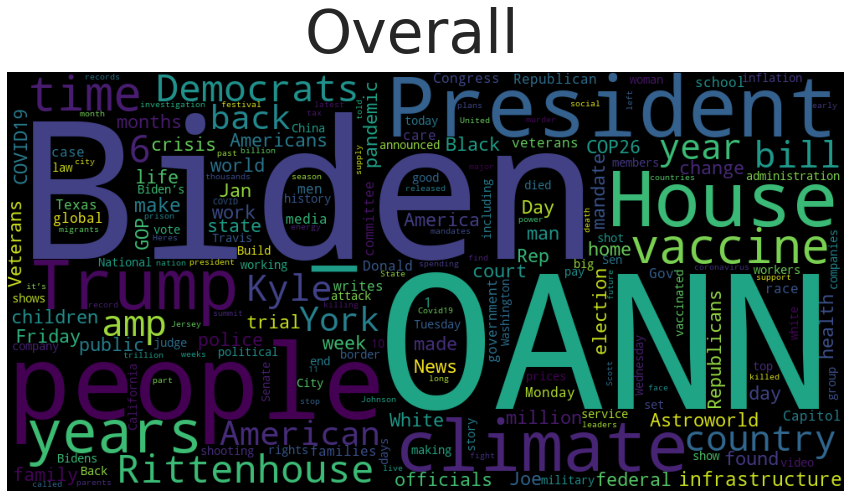

In [81]:
make_word_cloud(overall_df, 'Overall')

#### Conservative Word Cloud

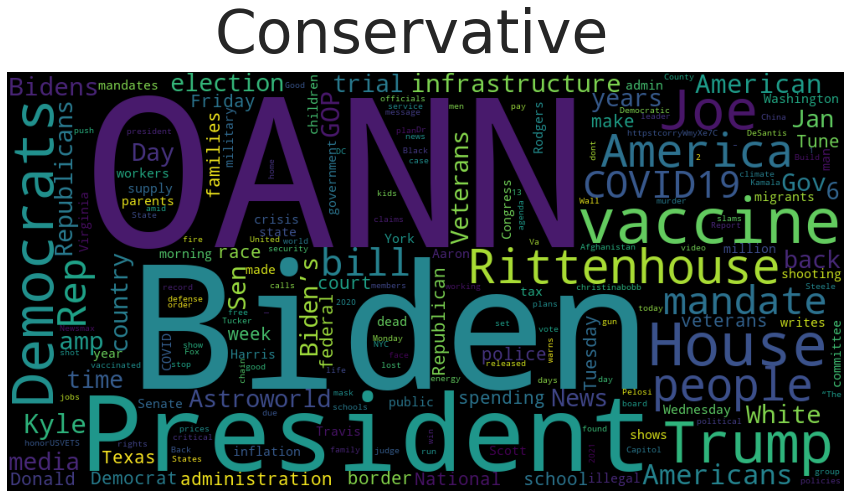

In [82]:
make_word_cloud(con_df, 'Conservative')

#### Moderate Word Cloud

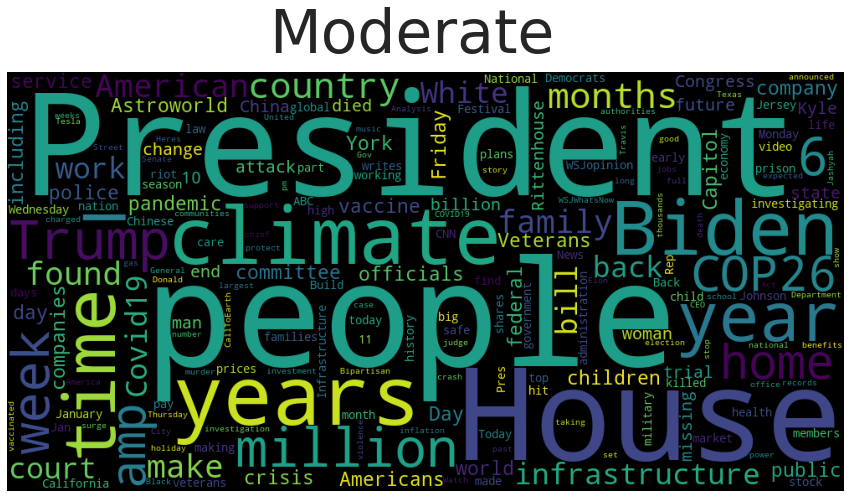

In [83]:
make_word_cloud(mod_df, 'Moderate')

#### Liberal Word Cloud

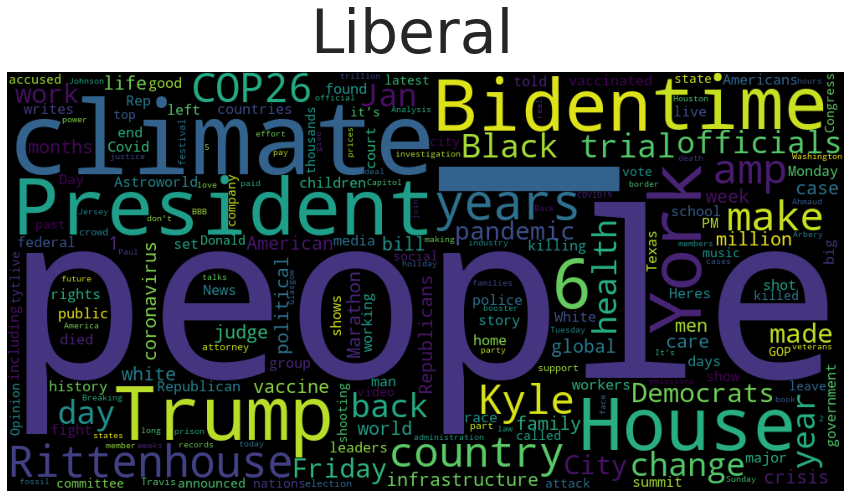

In [84]:
make_word_cloud(lib_df, 'Liberal')

#### Traditional News Word Cloud

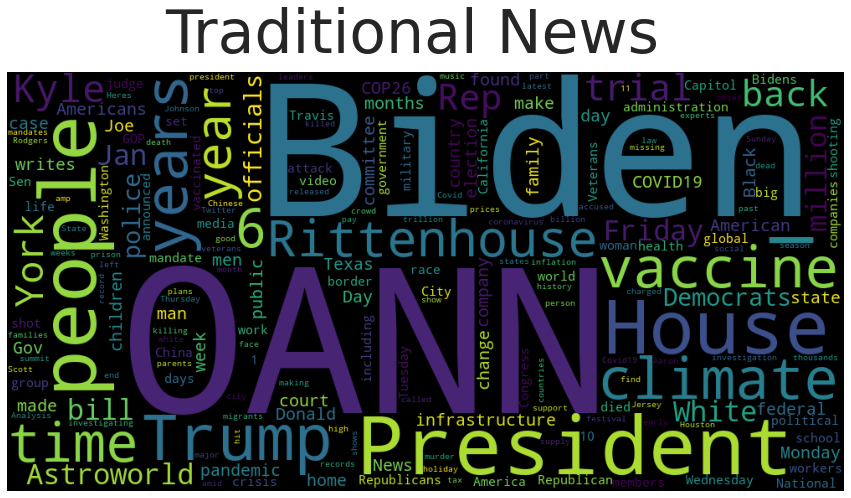

In [85]:
make_word_cloud(traditional_df, 'Traditional News')

#### Politician Word Cloud

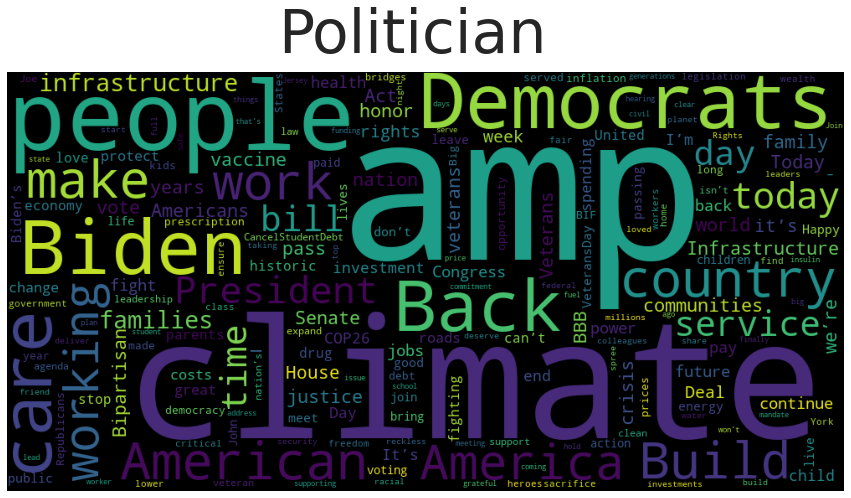

In [86]:
make_word_cloud(politician_df, 'Politician')

#### Alternative News Word Cloud

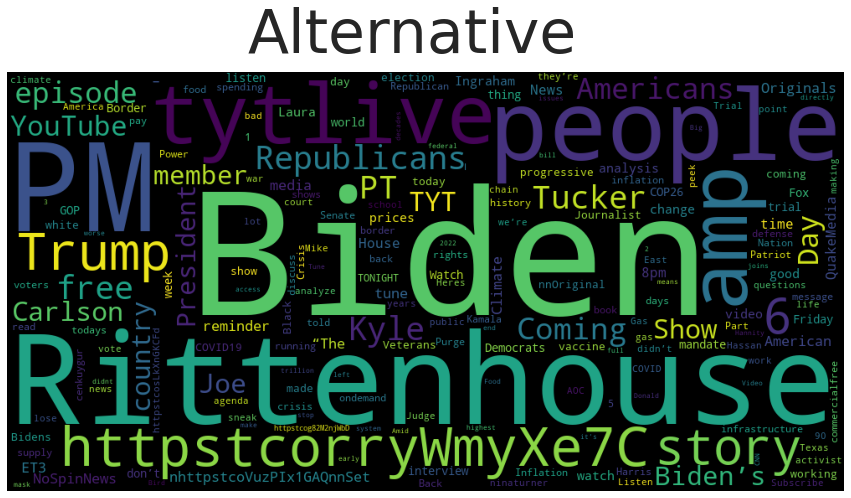

In [87]:
make_word_cloud(alternative_df, 'Alternative')

## Word Frequency Graph

Well be using word frequency bar graphs as another way to get a general idea of the topics most spoken about of the various populations of the data set. The first section will focus on the particular words being used while the second section will focus on entities referenced. The following word frequency graphs will be created for each section:
- Overall Population
- News Type comparison (Traditional News, Politicians, Alternative News)
- Political Alignment (Conservative, Moderate, Liberal)

### Words

#### Overall

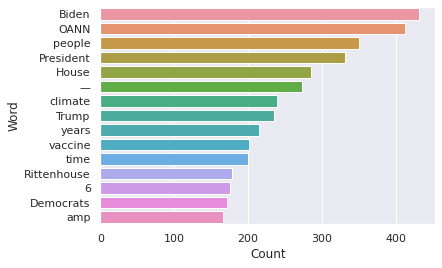

In [88]:
bar_comparison_word(title='Overall', sub_titles=[''], dfs=[overall_df], num_graph=1)

#### News Type

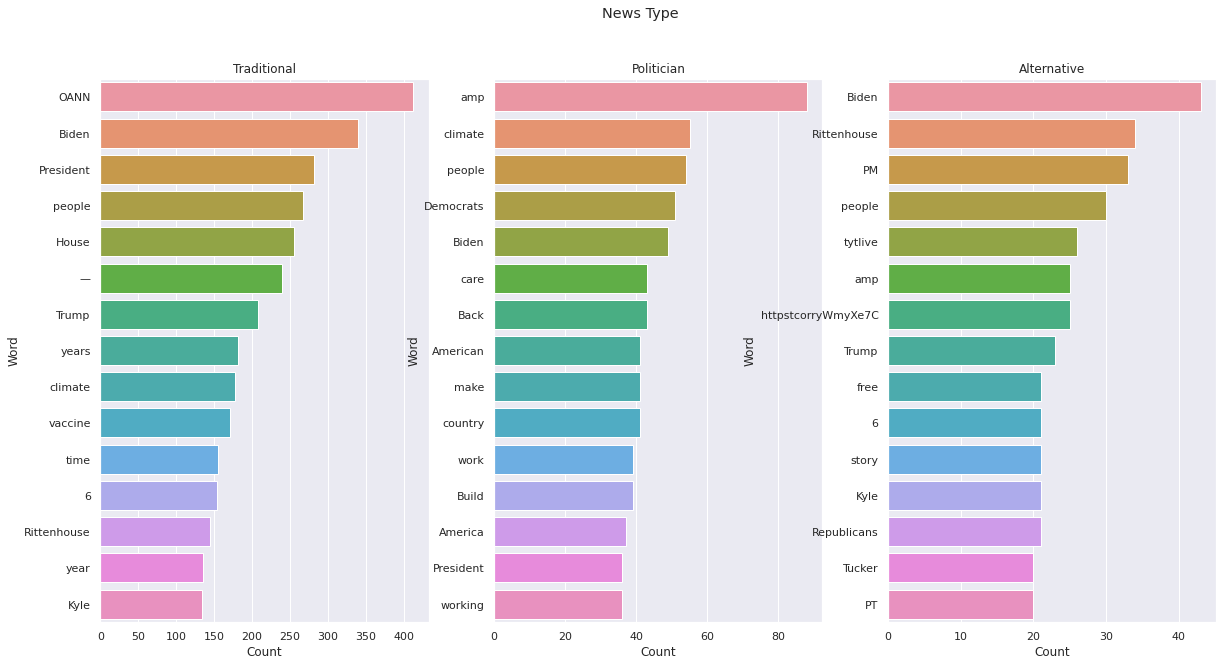

In [89]:
subtitles=['Traditional', 'Politician', 'Alternative']
data= [traditional_df, politician_df, alternative_df]
bar_comparison_word(title='News Type', sub_titles=subtitles, dfs=data, num_graph=3)

#### Political Alignment

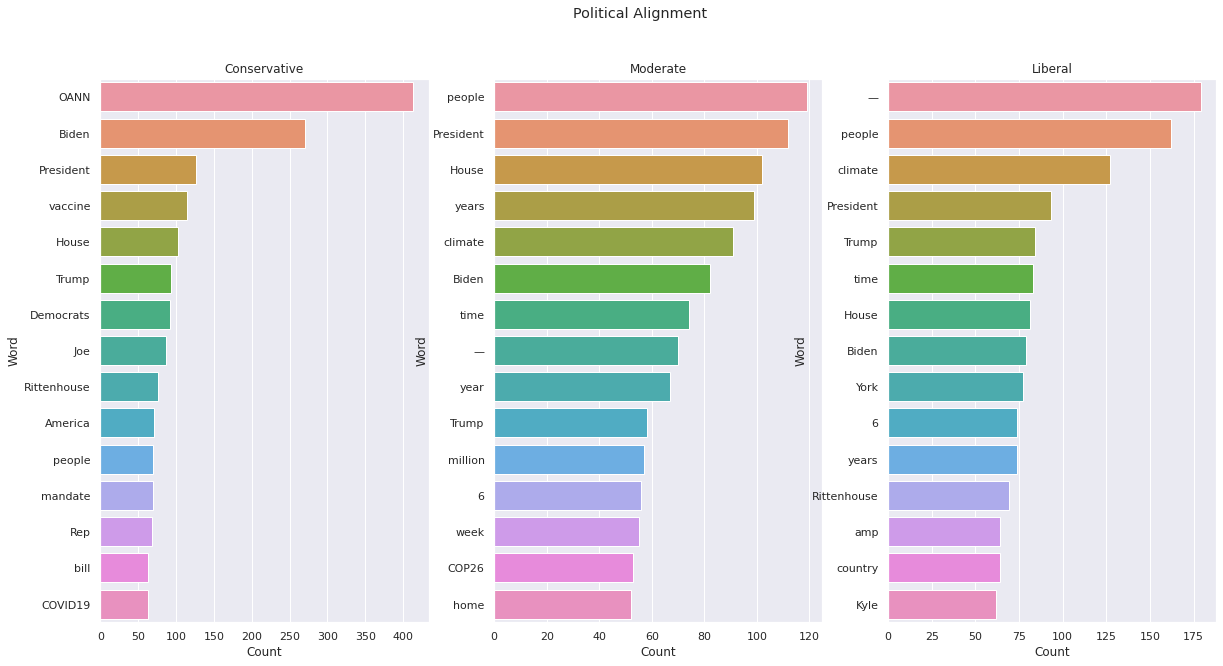

In [90]:
subtitles=['Conservative', 'Moderate', 'Liberal']
data= [con_df, mod_df, lib_df]
bar_comparison_word(title='Political Alignment', sub_titles=subtitles, dfs=data, num_graph=3)

### Named Entities

#### Overall

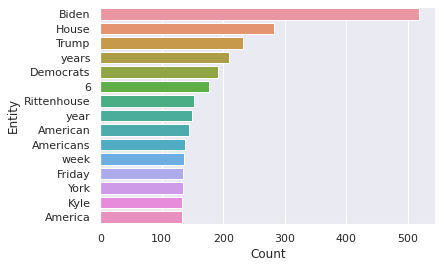

In [91]:
bar_comparison_NE(title='Named Entities', sub_titles=[''], dfs=[overall_df], num_graph=1 )

####  News Types

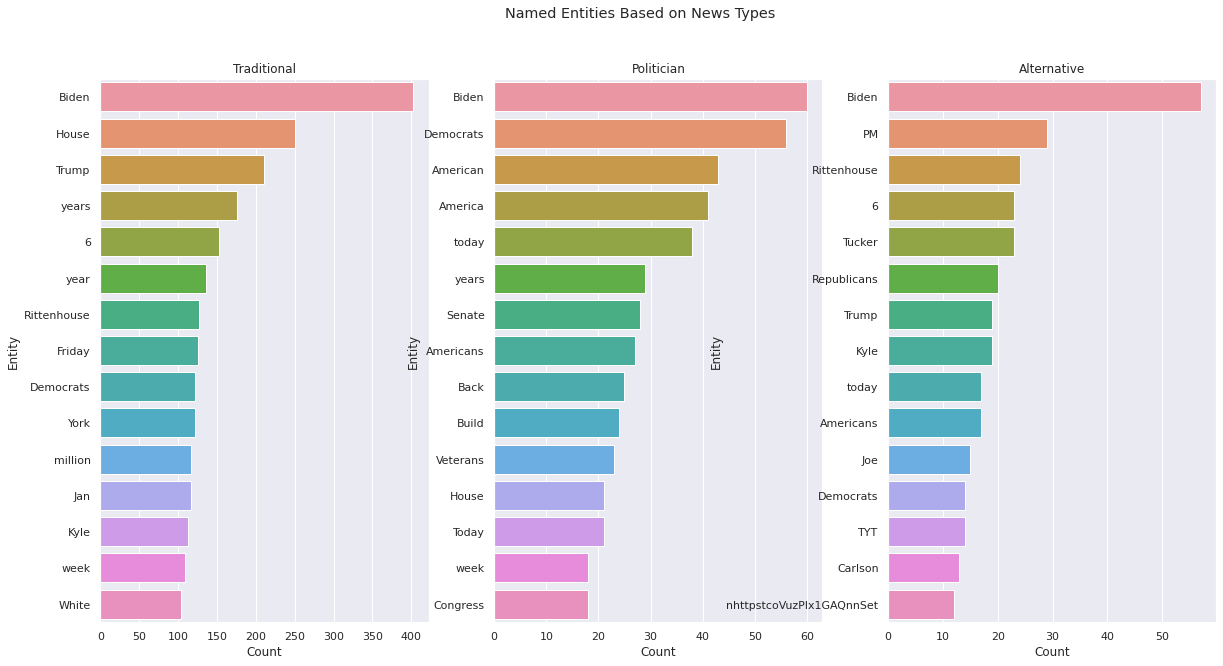

In [92]:
subtitles = ['Traditional', 'Politician', 'Alternative']
data = [traditional_df, politician_df, alternative_df]
bar_comparison_NE(title='Named Entities Based on News Types', sub_titles=subtitles, dfs=data, num_graph=3 )

#### Political Alignment

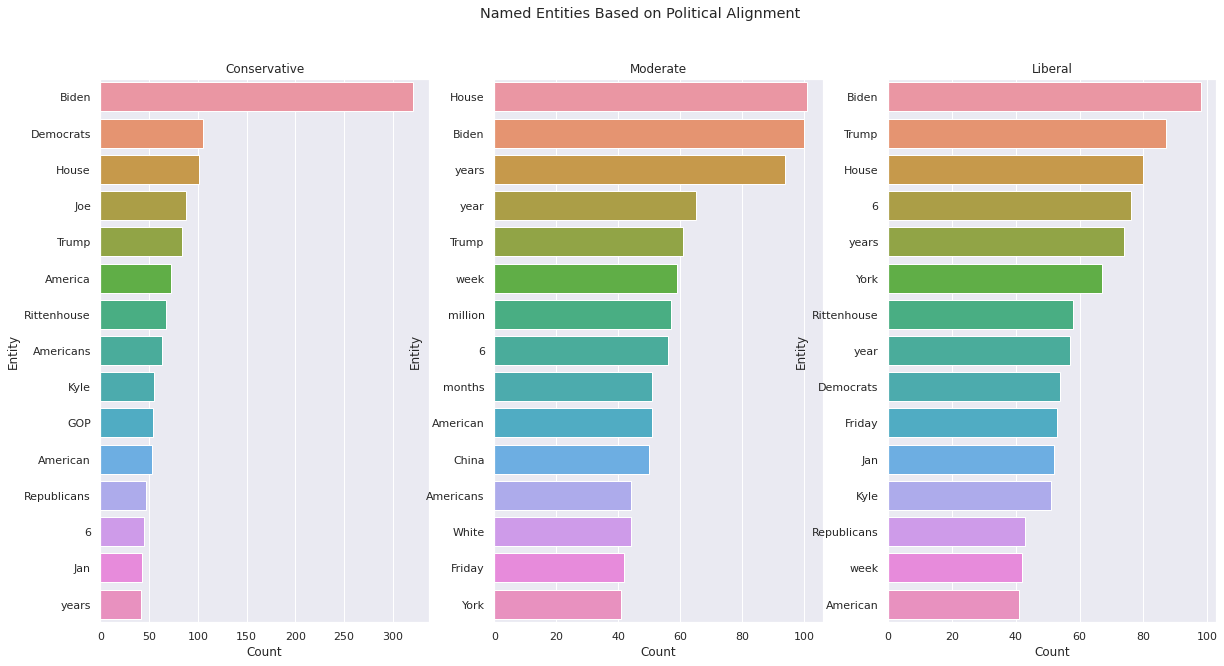

In [93]:
subtitles = ['Conservative', 'Moderate', 'Liberal']
data = [con_df, mod_df, lib_df]
bar_comparison_NE(title='Named Entities Based on Political Alignment', sub_titles=subtitles, dfs=data, num_graph=3 )

## Distribution Charts

Here I will be using histograms to evaluate the distribution of values of certain features based on other features. The three variables of which we will be finding the distributions of will be length, sentiment, and subjectivity. The populations being assessed will be:
- Overall Population
- News Type comparison (Traditional News, Politicians, Alternative News)
- Political Alignment (Conservative, Moderate, Liberal)

### Length Distributions

#### Overall 

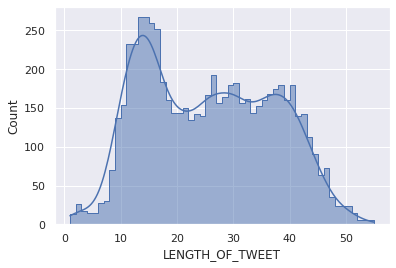

In [94]:
make_histogram(overall_df, 'LENGTH_OF_TWEET', 1)

#### News Type

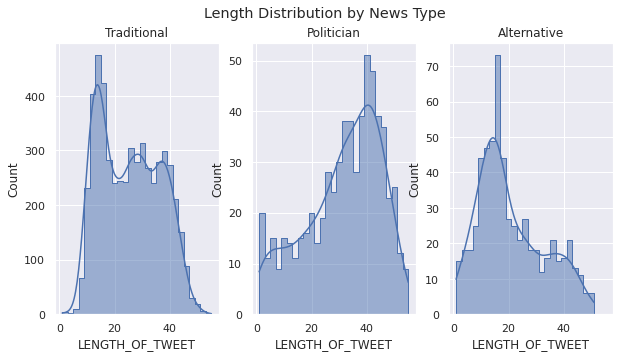

In [95]:
#NTL stands for News Type Length
subtitles_NTL = ['Traditional', 'Politician', 'Alternative']
df_list_NTL = [traditional_df, politician_df, alternative_df]
hist_comparison(title='Length Distribution by News Type', sub_titles=subtitles_NTL, dfs=df_list_NTL, attribute='LENGTH_OF_TWEET', binwidth=2, num_hist=3) 

#### Political Alignment

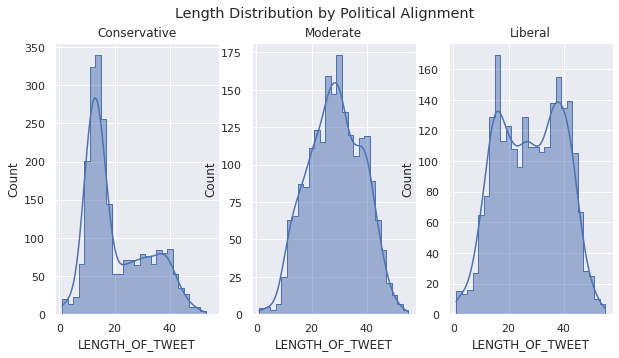

In [96]:
#PAL stands for Political Alignment Length
subtitles_PAL = ['Conservative', 'Moderate', 'Liberal']
df_list_PAL = [con_df, mod_df, lib_df]
hist_comparison(title='Length Distribution by Political Alignment', sub_titles=subtitles_PAL, dfs= df_list_PAL, attribute="LENGTH_OF_TWEET", binwidth=2, num_hist=3)

### Sentiment Distribution 

#### Overall

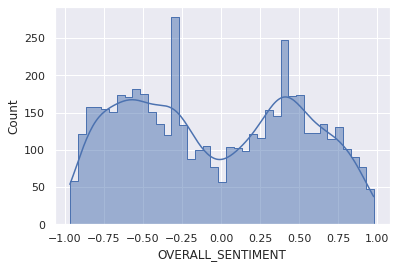

In [97]:
make_histogram(df=overall_df, attribute='OVERALL_SENTIMENT', bin_width=.05)

#### News Type

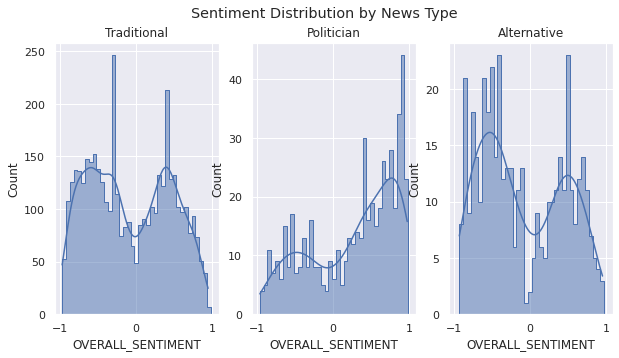

In [98]:
# NTS stands for News Type Sentiment
subtitles_NTS = ['Traditional', 'Politician', 'Alternative']
df_list_NTS = [traditional_df, politician_df, alternative_df]
hist_comparison(title='Sentiment Distribution by News Type', sub_titles=subtitles_NTS, dfs=df_list_NTS, attribute='OVERALL_SENTIMENT', binwidth=.05, num_hist=3) 

#### Political Alignment

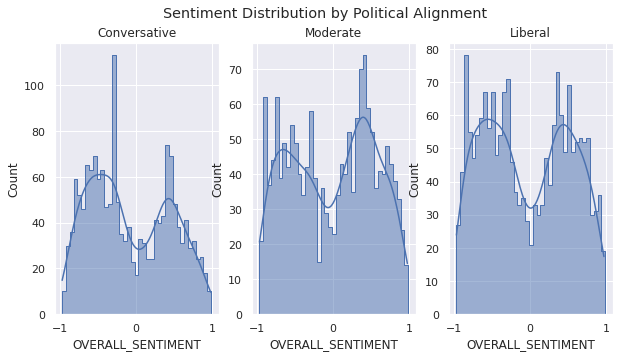

In [99]:
# PAS stands for Political Alignment Sentiment 
subtitles_PAS = ['Conversative', 'Moderate', 'Liberal']
df_list_PAS = [con_df, mod_df, lib_df]
hist_comparison(title='Sentiment Distribution by Political Alignment', sub_titles=subtitles_PAS, dfs=df_list_PAS, attribute='OVERALL_SENTIMENT', binwidth=.05, num_hist=3)

### Subjectivity Distribution

#### Overall

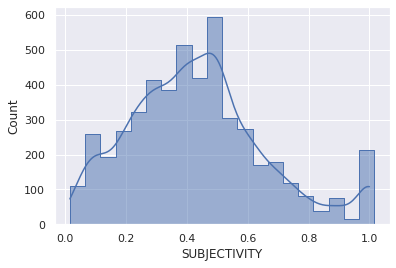

In [100]:
make_histogram(df=overall_df, attribute='SUBJECTIVITY', bin_width=.05)

#### News Type

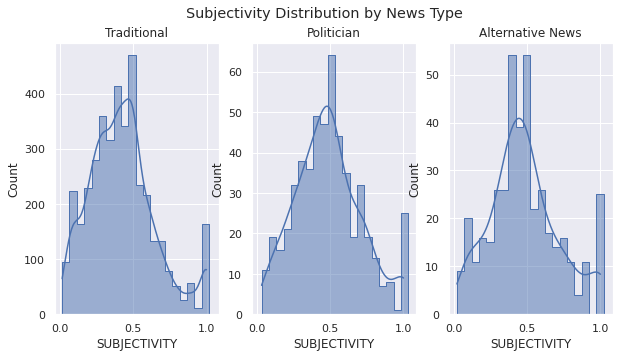

In [101]:
#NTSB stands for News Type Subjectivity
subtitles_NTSB = ['Traditional', 'Politician', 'Alternative News']
df_list_NTSB = [traditional_df, politician_df, alternative_df]
hist_comparison(title='Subjectivity Distribution by News Type', sub_titles=subtitles_NTSB, dfs=df_list_NTSB, attribute='SUBJECTIVITY', binwidth=.05, num_hist=3)

#### Political Alignment 

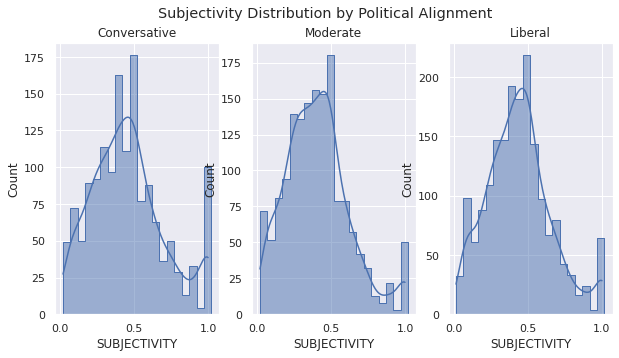

In [102]:
# PASB stands for Political Alignment Subjectivity
subtitles_PASB = ['Conversative', 'Moderate', 'Liberal']
df_list_PASB = [con_df, mod_df, lib_df]
hist_comparison(title='Subjectivity Distribution by Political Alignment', sub_titles=subtitles_PASB, dfs=df_list_PASB, attribute='SUBJECTIVITY', binwidth=.05, num_hist=3)

## Candle Plots Distributions

Here I will be visualizing and analyzing the distribution of the data again, but through the use of candle plots. The primary variables being examined will be the same as the previously shown histogram visualizations with addition of an intersection and day of the week analysis. We will also be analyzing the same populations as well:
- Overall Population
- News Type comparison (Traditional News, Politicians, Alternative News)
- Political Alignment (Conservative, Moderate, Liberal)
- Intersection (News Type and Political Alignment)
- Day of the Week

### Sentiment Analysis

#### News Type

In [103]:
make_candle_plot(df=overall_df, groupby_='NEWS_SOURCES_TYPE', attribute='OVERALL_SENTIMENT' )

  NEWS_SOURCES_TYPE OVERALL_SENTIMENT                                
                                 mean     min     max      q1      q3
0       Alternative         -0.091990 -0.9260  0.9551 -0.5574  0.4404
1        Politician          0.273437 -0.9590  0.9769 -0.2500  0.7650
2       Traditional         -0.078498 -0.9691  0.9477 -0.5574  0.4019


#### Political Alignment

In [104]:
make_candle_plot(df=overall_df, groupby_='POLITICAL_ALIGNMENT', attribute='OVERALL_SENTIMENT' )

  POLITICAL_ALIGNMENT OVERALL_SENTIMENT                                  
                                   mean     min     max      q1        q3
0        Conservative         -0.083473 -0.9691  0.9769 -0.5423  0.401900
1             Liberal         -0.036200 -0.9643  0.9686 -0.5423  0.450625
2            Moderate         -0.007700 -0.9643  0.9735 -0.5267  0.442725


#### Intersection 

In [105]:
make_candle_plot_multi(df=overall_df, groupby_=['POLITICAL_ALIGNMENT', 'NEWS_SOURCES_TYPE'], attribute='OVERALL_SENTIMENT' )

  POLITICAL_ALIGNMENT NEWS_SOURCES_TYPE OVERALL_SENTIMENT                  \
                                                     mean     min     max   
0        Conservative       Alternative          0.013108 -0.9169  0.9401   
1        Conservative        Politician          0.079179 -0.9590  0.9769   
2        Conservative       Traditional         -0.122130 -0.9691  0.9246   
3             Liberal       Alternative         -0.206316 -0.9260  0.9551   
4             Liberal        Politician          0.316979 -0.9246  0.9686   
5             Liberal       Traditional         -0.056697 -0.9643  0.9393   
6            Moderate        Politician          0.392892 -0.9529  0.9735   
7            Moderate       Traditional         -0.063012 -0.9643  0.9477   

                                   INTERSECTION  
        q1       q3                              
0 -0.47670  0.50995  Conservative / Alternative  
1 -0.51060  0.66465   Conservative / Politician  
2 -0.54995  0.34000  Conserva

#### Day of Week

In [106]:
make_candle_plot(df=overall_df, groupby_='DAY_OF_WEEK', attribute='OVERALL_SENTIMENT' )

  DAY_OF_WEEK OVERALL_SENTIMENT                                  
                           mean     min     max       q1       q3
0      Friday         -0.094164 -0.9691  0.9702 -0.57190  0.38180
1      Monday         -0.015029 -0.9590  0.9769 -0.45880  0.42150
2    Saturday         -0.042628 -0.9568  0.9501 -0.47670  0.44040
3      Sunday          0.123733 -0.9382  0.9709 -0.32050  0.57190
4    Thursday         -0.035628 -0.9595  0.9696 -0.54230  0.45880
5     Tuesday         -0.057400 -0.9643  0.9735 -0.52670  0.40190
6   Wednesday         -0.014977 -0.9666  0.9642 -0.53035  0.46255


### Subjectivity Analysis

#### News Type

In [107]:
make_candle_plot(df=overall_df, groupby_='NEWS_SOURCES_TYPE', attribute='SUBJECTIVITY' )

  NEWS_SOURCES_TYPE SUBJECTIVITY                          
                            mean    min  max     q1     q3
0       Alternative     0.482303  0.022  1.0  0.333  0.600
1        Politician     0.487158  0.033  1.0  0.333  0.625
2       Traditional     0.425302  0.016  1.0  0.266  0.539


#### Political_Alignment

In [108]:
make_candle_plot(df=overall_df, groupby_='POLITICAL_ALIGNMENT', attribute='SUBJECTIVITY' )

  POLITICAL_ALIGNMENT SUBJECTIVITY                            
                              mean    min  max      q1      q3
0        Conservative     0.459723  0.022  1.0  0.2880  0.6000
1             Liberal     0.440667  0.016  1.0  0.2960  0.5500
2            Moderate     0.410750  0.022  1.0  0.2515  0.5085


#### Intersection

In [109]:
make_candle_plot_multi(df=overall_df, groupby_=['POLITICAL_ALIGNMENT', 'NEWS_SOURCES_TYPE'], attribute='SUBJECTIVITY' )

  POLITICAL_ALIGNMENT NEWS_SOURCES_TYPE SUBJECTIVITY                       \
                                                mean    min  max       q1   
0        Conservative       Alternative     0.487131  0.022  1.0  0.33300   
1        Conservative        Politician     0.509770  0.033  1.0  0.36800   
2        Conservative       Traditional     0.447448  0.022  1.0  0.25850   
3             Liberal       Alternative     0.477236  0.025  1.0  0.33300   
4             Liberal        Politician     0.502303  0.050  1.0  0.35700   
5             Liberal       Traditional     0.427719  0.016  1.0  0.28425   
6            Moderate        Politician     0.453429  0.050  1.0  0.29400   
7            Moderate       Traditional     0.404944  0.022  1.0  0.25000   

                          INTERSECTION  
        q3                              
0  0.60000  Conservative / Alternative  
1  0.65000   Conservative / Politician  
2  0.58325  Conservative / Traditional  
3  0.60000       Liberal

#### Day of Week

In [110]:
make_candle_plot(df=overall_df, groupby_='DAY_OF_WEEK', attribute='SUBJECTIVITY' )

  DAY_OF_WEEK SUBJECTIVITY                             
                      mean    min  max       q1      q3
0      Friday     0.435620  0.022  1.0  0.28300  0.5500
1      Monday     0.453771  0.033  1.0  0.27850  0.5805
2    Saturday     0.445725  0.025  1.0  0.28750  0.5780
3      Sunday     0.451554  0.050  1.0  0.30550  0.5500
4    Thursday     0.437998  0.016  1.0  0.27275  0.5580
5     Tuesday     0.429448  0.025  1.0  0.26000  0.5500
6   Wednesday     0.428485  0.023  1.0  0.27650  0.5410


## Pie Charts

I will be using pie charts in order to compare the percentages of certain features in varying population. This will help get a good gauge on how the different population tend to relay their messages. Here I will be focusing on Sentiment and Subjectivity by separating these features into 3 subsections (sentiment: positive, neutral, negative ; subjectivity: objective, somewhat subjective, highly subjective.) The charts will be arranged as following:
- Overall
- News Type comparison (Traditional News, Politicians, Alternative News)
- Political Alignment (Conservative, Moderate, Liberal)

### Sentiment Analysis

#### Overall

           Count
Sentiment       
Neutral     2199
Negative    1725
Positive    1195


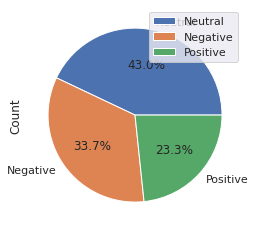

In [111]:
make_pie_sent(overall_df, 'OVERALL_SENTIMENT')

#### News Type

           Count
Sentiment       
Neutral     1867
Negative    1450
Positive     829
           Count
Sentiment       
Neutral      180
Negative     102
Positive     263
           Count
Sentiment       
Neutral      152
Negative     173
Positive     103


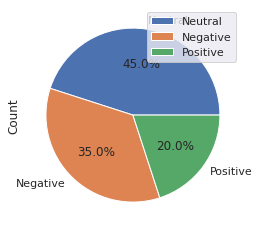

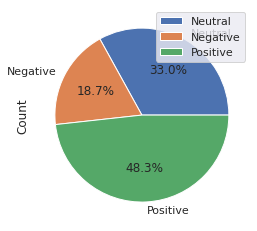

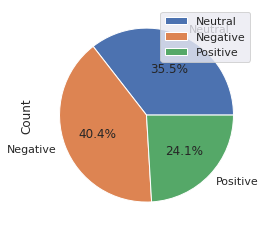

In [112]:
make_pie_sent(traditional_df, 'OVERALL_SENTIMENT') #TRADITIONAL
make_pie_sent(politician_df, 'OVERALL_SENTIMENT') #POLITICIAN
make_pie_sent(alternative_df, 'OVERALL_SENTIMENT') #ALTERNATIVE

#### Political Alignment

           Count
Sentiment       
Neutral      723
Negative     580
Positive     326
           Count
Sentiment       
Neutral      711
Negative     517
Positive     404
           Count
Sentiment       
Neutral      765
Negative     628
Positive     465


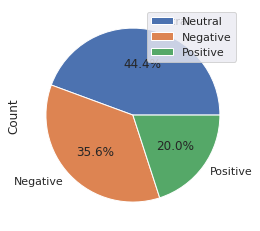

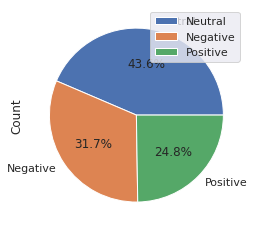

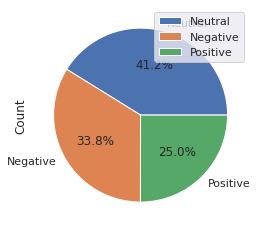

In [113]:
make_pie_sent(con_df, 'OVERALL_SENTIMENT') #CONSERVATIVE
make_pie_sent(mod_df, 'OVERALL_SENTIMENT') #MODERATE
make_pie_sent(lib_df, 'OVERALL_SENTIMENT') #LIBERAL

### Subjectivity

#### Overall

                     Count
Subjectivity              
Somewhat Subjective   2430
Objective             1772
Highly Subjective      741


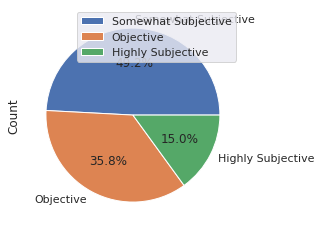

In [114]:
make_pie_sub(overall_df,'SUBJECTIVITY')

#### News Type

                     Count
Subjectivity              
Somewhat Subjective   1935
Objective             1518
Highly Subjective      537
                     Count
Subjectivity              
Somewhat Subjective    276
Objective              143
Highly Subjective      118
                     Count
Subjectivity              
Somewhat Subjective    219
Objective              111
Highly Subjective       86


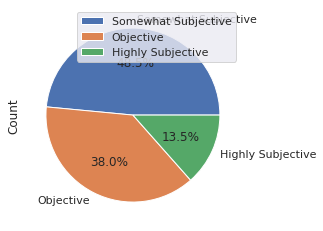

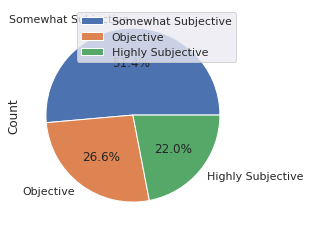

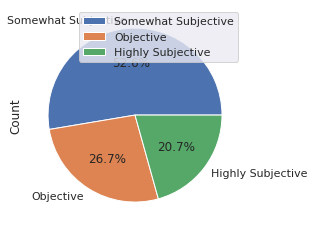

In [115]:
make_pie_sub(traditional_df,'SUBJECTIVITY')
make_pie_sub(politician_df,'SUBJECTIVITY')
make_pie_sub(alternative_df,'SUBJECTIVITY')

#### Political Alignment 

                     Count
Subjectivity              
Somewhat Subjective    706
Objective              517
Highly Subjective      283
                     Count
Subjectivity              
Somewhat Subjective    762
Objective              645
Highly Subjective      188
                     Count
Subjectivity              
Somewhat Subjective    962
Objective              610
Highly Subjective      270


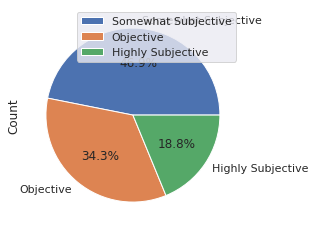

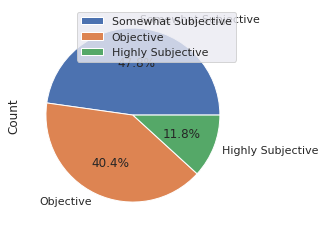

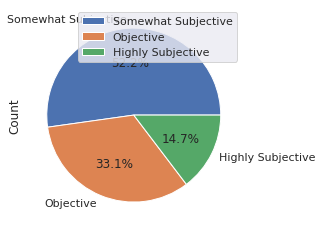

In [116]:
make_pie_sub(con_df,'SUBJECTIVITY')
make_pie_sub(mod_df,'SUBJECTIVITY')
make_pie_sub(lib_df,'SUBJECTIVITY')